In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Dataset, SVD, Reader
from surprise.model_selection import cross_validate
from surprise.dump import dump
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [3]:
%cd ..

c:\Users\CARNOT\movies-recommendation


In [4]:
%pwd

'c:\\Users\\CARNOT\\movies-recommendation'

In [19]:

def parse(file):
    data = open(r"data\processed\data1.csv", mode="w")
    with open(file) as f:
        lines = f.readlines()
        for k in range(len(lines)):
            line = lines[k]
            line = line.strip()
            if line.endswith(":"):
                movie_id = line.replace(":", "")
            else:
                row = [x for x in line.split(",")]
                row.insert(0, movie_id)
                data.write(",".join(row))
                data.write("\n")

In [20]:
file_path = r"data\netflix price data\combined_data_1.txt"
parse(file_path)

In [42]:
df_years = []
users_id = []
movie_id = []

df_viewmovies = pd.read_csv("data1.csv", names= ["movie_id", "customer_id", "rating", "ratingdate"])
df_viewmovies["rating"] = df_viewmovies["rating"].astype(np.float32)
df_viewmovies.ratingdate = pd.to_datetime(df_viewmovies.ratingdate)


In [23]:
df_viewmovies["year"] = df_viewmovies.ratingdate.dt.year
df_viewmovies.cnt = 1.0
df_viewmovies.head()

,movie_id,customer_id,rating,ratingdate,year
0,1,1488844,3.0,2005-09-06,2005
1,1,822109,5.0,2005-05-13,2005
2,1,885013,4.0,2005-10-19,2005
3,1,30878,4.0,2005-12-26,2005
4,1,823519,3.0,2004-05-03,2004


In [24]:
df_viewmovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24053764 entries, 0 to 24053763
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movie_id     int64         
 1   customer_id  int64         
 2   rating       float32       
 3   ratingdate   datetime64[ns]
 4   year         int64         
dtypes: datetime64[ns](1), float32(1), int64(3)
memory usage: 825.8 MB


In [26]:
df_viewmovies.isna().sum()

movie_id       0
customer_id    0
rating         0
ratingdate     0
year           0
dtype: int64

Text(0.5, 1.0, 'Production per year')

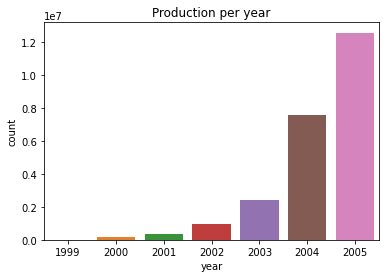

In [29]:
sns.countplot(data=df_viewmovies, x="year")
plt.xlabel("year")
plt.title("Production per year")

In [31]:
del df_viewmovies["year"]

In [32]:
df_viewmovies.columns

Index(['movie_id', 'customer_id', 'rating', 'ratingdate'], dtype='object')

In [43]:
f = ['count','mean']

df_movie_summary = df_viewmovies.groupby('movie_id')['rating'].agg(f)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
keep_movie_list = df_movie_summary[~(df_movie_summary['count'] < movie_benchmark)].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df_viewmovies.groupby('customer_id')['rating'].agg(f)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
keep_cust_list = df_cust_summary[~(df_cust_summary['count'] < cust_benchmark)].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

# removing the index in keep_movie_list in keep_cust_list while maintaining the remaining index in the 
# keep_cust_list
index_to_keep = np.union1d(keep_cust_list, keep_movie_list)
print(len(index_to_keep))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0
96196


In [44]:
print('Original Shape: {}'.format(df_viewmovies.shape))
df_viewmovies = df_viewmovies.loc[index_to_keep]
print('After Trim Shape: {}'.format(df_viewmovies.shape))

Original Shape: (24053764, 4)
After Trim Shape: (96196, 4)


In [47]:
np.count_nonzero([0, 1,2,34])

3

In [60]:
movie_count_mean = df_viewmovies.groupby("movie_id", as_index=False).aggregate(movie_id_ratingcount=("rating",pd.Series.count), movie_id_ratingmean=("rating", np.mean))

In [55]:
movie_count_mean.head()

,movie_id,movie_id_ratingcount,movie_id_ratingmean
0,1,125.0,3.840000
1,2,38.0,3.631579
2,3,454.0,3.555066
3,4,27.0,2.666667
4,5,271.0,4.033210


In [54]:
user_count_mean = df_viewmovies.groupby("customer_id", as_index=False).aggregate(user_id_ratingcount=("rating",pd.Series.count), user_id_ratingmean=("rating", np.mean))

In [56]:
user_count_mean.head()

,customer_id,user_id_ratingcount,user_id_ratingmean
0,6,1.0,4.0
1,10,1.0,5.0
2,97,1.0,4.0
3,183,1.0,4.0
4,188,1.0,2.0


In [61]:
df = pd.merge(df_viewmovies, movie_count_mean, on="movie_id")
df = pd.merge(df, user_count_mean, on="customer_id")
df.head()

,movie_id,customer_id,rating,ratingdate,movie_id_ratingcount,movie_id_ratingmean,user_id_ratingcount,user_id_ratingmean
0,1,124105,4.0,2004-08-05,125.0,3.840000,1.0,4.000000
1,1,1248029,3.0,2004-04-22,125.0,3.840000,3.0,3.666667
2,58,1248029,3.0,2004-09-27,646.0,3.614551,3.0,3.666667
3,426,1248029,5.0,2004-08-08,147.0,3.183673,3.0,3.666667
4,1,1842128,4.0,2004-05-09,125.0,3.840000,1.0,4.000000


In [65]:
movies_title = pd.read_csv(r"data\netflix price data\movie_titles.csv", encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
movies_title.head()

,Movie_Id,Year,Name
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [67]:
df.columns

Index(['movie_id', 'customer_id', 'rating', 'ratingdate',
       'movie_id_ratingcount', 'movie_id_ratingmean', 'user_id_ratingcount',
       'user_id_ratingmean'],
      dtype='object')

In [71]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['customer_id', 'movie_id', 'rating']][:100000], reader)

trainer = SVD()

cross_validate(trainer, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0196  1.0275  1.0288  1.0341  1.0300  1.0280  0.0047  
MAE (testset)     0.8152  0.8226  0.8233  0.8271  0.8251  0.8226  0.0040  
Fit time          8.50    8.38    8.35    7.81    8.04    8.22    0.25    
Test time         1.04    0.24    0.22    0.21    0.22    0.39    0.33    


{'test_rmse': array([1.0195877 , 1.02749844, 1.02883566, 1.03408994, 1.02995998]),
 'test_mae': array([0.81520485, 0.82257906, 0.82331946, 0.82705785, 0.8250587 ]),
 'fit_time': (8.496544361114502,
  8.377563714981079,
  8.35404634475708,
  7.81378436088562,
  8.043336391448975),
 'test_time': (1.0361754894256592,
  0.23800373077392578,
  0.220001220703125,
  0.21399354934692383,
  0.21699118614196777)}

In [73]:
trainset = data.build_full_trainset()
trainer.fit(trainset)

In [75]:
dump("models/svd.pkl", algo=trainer)